In [1]:
%matplotlib inline

import sys
import copy
import rospy
import geometry_msgs.msg
from sensor_msgs.msg import Image ,PointCloud2
import numpy as np
import cv2
import matplotlib.pyplot as plt
from std_msgs.msg import String
from moveit_commander.conversions import pose_to_list
from utils import grasp_utils
from cv_bridge import CvBridge, CvBridgeError

from act_recog.srv import Recognize,RecognizeResponse,RecognizeRequest
import ros_numpy

In [2]:
bridge = CvBridge()
rospy.init_node("waving_person_test", anonymous=True)

In [3]:
recognize_action = rospy.ServiceProxy('recognize_act', Recognize) 


In [4]:
# para quitar fondo, es necesario rgbd de la camara del robot
def removeBackground(points_msg,distance = 2):
    # Obtengo rgb
    points_data = ros_numpy.numpify(points_msg)
    image_data = points_data['rgb'].view((np.uint8, 4))[..., [2, 1, 0]]   
    image=cv2.cvtColor(image_data, cv2.COLOR_BGR2RGB)
    image = points_data['rgb'].view((np.uint8, 4))[..., [2, 1, 0]]
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)    

    # Quito todos los pixeles que esten a una distancia mayor y/o a una distancia menor
    # Para poder obtener una mascara con ceros y unos
    zs_no_nans=np.where(~np.isnan(points_data['z']),points_data['z'],10)
    img_corrected = np.where((zs_no_nans < distance + 0.3),zs_no_nans,0)
    #img_corrected = np.where((img_corrected >1.5),img_corrected,0)
    img_corrected = np.where((img_corrected == 0),img_corrected,1)

    # operacion AND entre la imagen original y la mascara para quitar fondo (background)
    #img_corrected = img_corrected.astype(np.uint8)
    masked_image = cv2.bitwise_and(rgb_image, rgb_image, mask=img_corrected.astype(np.uint8))
    return rgb_image, masked_image


In [5]:
req = RecognizeRequest()

In [63]:
req.visual=0
# reqAct.in_ --> 5  para detectar Waving en Restaurant
req.in_ = 5
resAct=recognize_action(req)
print(resAct.i_out)

1


True

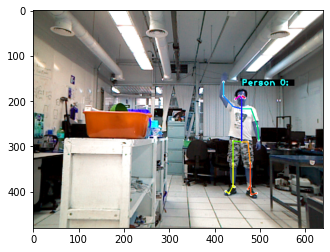

In [64]:
img = bridge.imgmsg_to_cv2(resAct.im_out.image_msgs[0])
#resAct.im_out.image_msgs
plt.imshow(img)
cv2.imwrite("waveTest.jpg",img)

In [46]:
cv2.imwrite("waveTest.jpg",img)

True

In [60]:
dataout = bridge.imgmsg_to_cv2(resAct.im_out.image_msgs[1])
print(dataout)

[[[493.61792 196.29082]
  [446.52078 224.66733]
  [460.58432 227.01666]
  [500.72073 274.1244 ]
  [569.2018  269.49628]
  [441.71756 220.03612]
  [460.67722 288.32864]
  [495.93088 293.18698]
  [439.34772 323.72177]
  [444.0236  326.04324]
  [555.021   344.97345]
  [540.8159  444.062  ]
  [427.66013 321.43454]
  [512.4987  312.0726 ]
  [495.93304 392.20856]
  [484.25732 184.5501 ]
  [493.6632  196.19139]
  [462.979   189.27396]
  [  0.        0.     ]
  [517.19904 406.37775]
  [514.8843  403.93933]
  [488.93347 403.91   ]
  [595.1005  455.9202 ]
  [576.30615 462.95966]
  [531.376   453.51837]]

 [[  0.        0.     ]
  [245.86337 217.72173]
  [285.97464 217.67192]
  [309.53305 278.93042]
  [278.92352 286.04037]
  [205.74573 217.63237]
  [196.22078 271.88107]
  [  0.        0.     ]
  [241.18047 321.3961 ]
  [271.78473 323.7875 ]
  [288.40945 302.5603 ]
  [271.86685 368.6071 ]
  [215.20567 319.05203]
  [196.4004  293.08405]
  [217.59758 363.87674]
  [  0.        0.     ]
  [  0.       

In [72]:
print(dataout[0,15:19,:])
b = dataout[0,15:19,:]
print(b.shape)

[[484.25732 184.5501 ]
 [493.6632  196.19139]
 [462.979   189.27396]
 [  0.        0.     ]]
(4, 2)


In [83]:
aa = np.concatenate((dataout[0,0:1,:],dataout[0,15:19,:]),axis=0)
print(aa)

aa = np.concatenate((aa,[[0,0]]))
print(aa)

[[493.61792 196.29082]
 [484.25732 184.5501 ]
 [493.6632  196.19139]
 [462.979   189.27396]
 [  0.        0.     ]]
[[493.61791992 196.29081726]
 [484.25732422 184.5500946 ]
 [493.66320801 196.19139099]
 [462.97900391 189.2739563 ]
 [  0.           0.        ]
 [  0.           0.        ]]


In [74]:
c = dataout[0,0:1,:]
print(dataout[0,0,:])
print(c.shape)

[493.61792 196.29082]
(1, 2)


In [86]:
ab = np. count_nonzero(aa,axis=0) 
print(ab[0])

4


In [90]:
su = np.sum(aa,axis=0)
print(su)
print(su / ab[0])

[1934.51745605  766.30625916]
[483.62936401 191.57656479]
